In [1]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import lightgbm

import os
import pickle
import sys
import warnings
from glob import glob


In [2]:
dataset_dir="../data_dir"

In [3]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    # DataFrameのindexを設定します。
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels


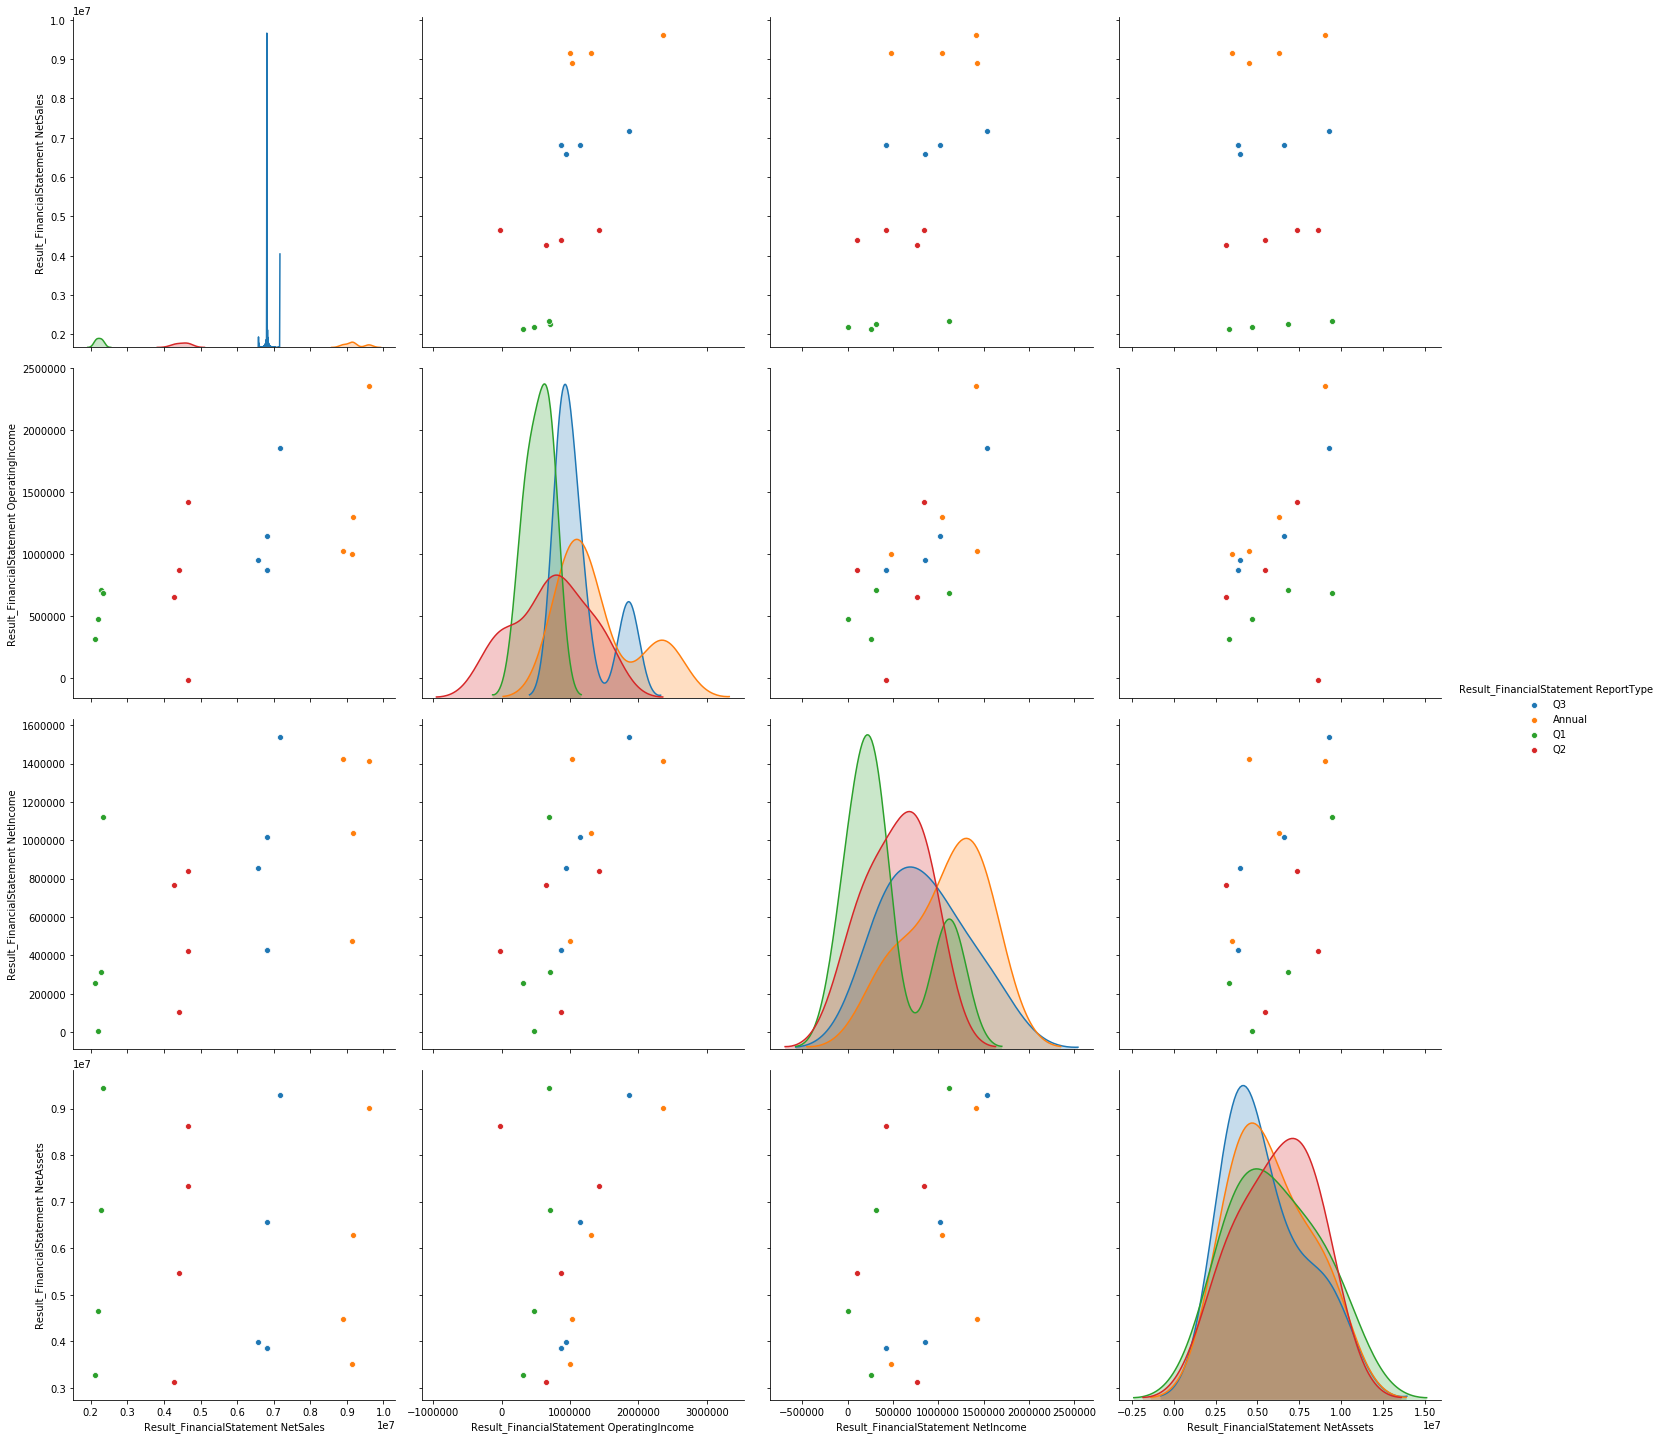

In [4]:
# stock_finの読み込み
fin = dfs["stock_fin"].copy()

# 銘柄コード9984にデータを絞る
code = 9984
fin_data = fin[fin["Local Code"] == code].copy()

# 日付列をpd.Timestamp型に変換してindexに設定
fin_data["datetime"] = pd.to_datetime(fin_data["base_date"])
fin_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
fin_data = fin_data[:"2019"]

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# プロット
sns.pairplot(fin_data[columns], hue="Result_FinancialStatement ReportType", height=5)

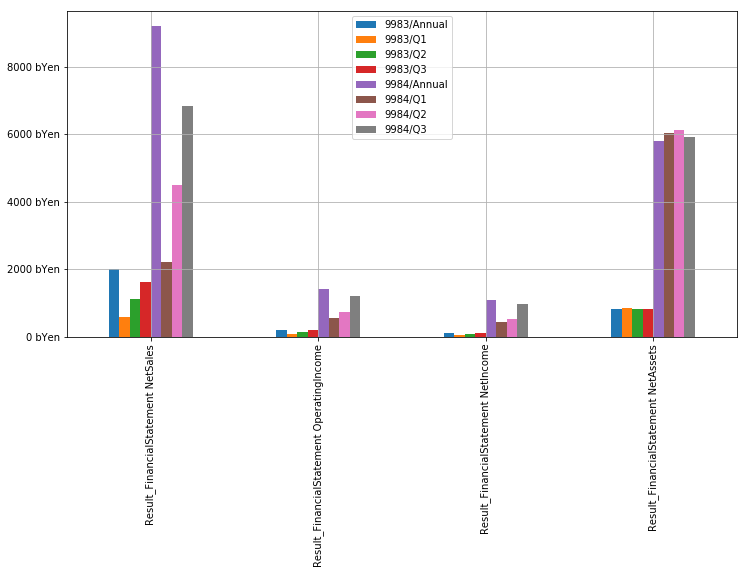

In [5]:
# stock_finの読み込み
fin = dfs["stock_fin"]

# 銘柄コード9984と9983を比較する
codes = [9984, 9983]

multi_df = dict()

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# 比較対象の銘柄コード毎に処理
for code in codes:
    # 特定の銘柄コードに絞り込み
    fin_data = fin[fin["Local Code"] == code]
    # 2019年までの値を表示
    fin_data = fin_data[:"2019"].copy()
    # 重複を排除
    fin_data.drop_duplicates(
        subset=[
            "Local Code",
            "Result_FinancialStatement FiscalYear",
            "Result_FinancialStatement ReportType"
        ],
        keep="last", inplace=True)
    # プロット対象のカラムを取得
    _fin_data = fin_data[columns]
    # 決算期毎の平均を取得
    multi_df[code] = _fin_data[columns].groupby("Result_FinancialStatement ReportType").mean()

# 銘柄毎に処理していたものを結合
multi_df = pd.concat(multi_df)
# 凡例を調整
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
# プロット
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
# Y軸のラベルを調整
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))

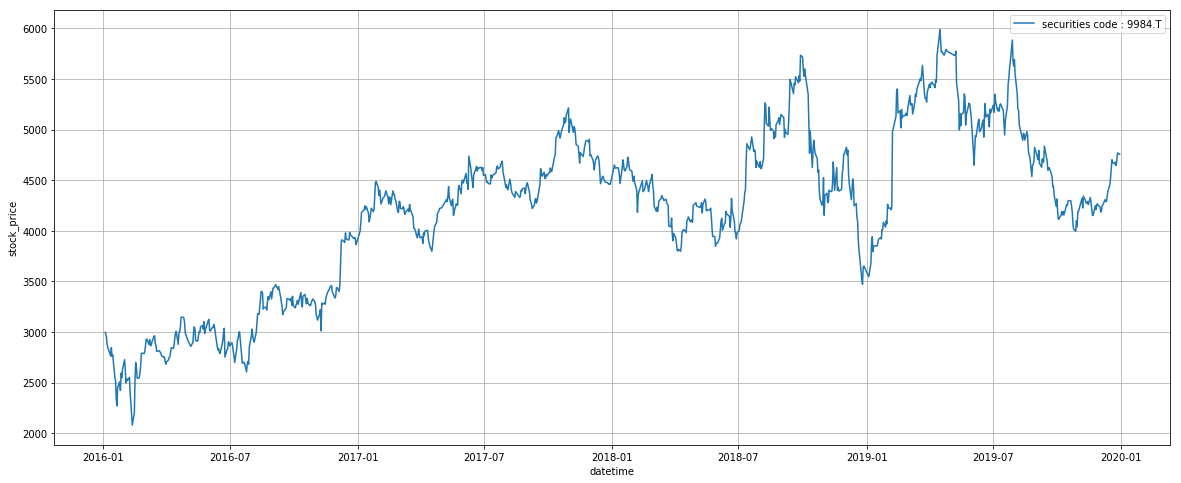

In [6]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"]

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label=f"securities code : {code}.T")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

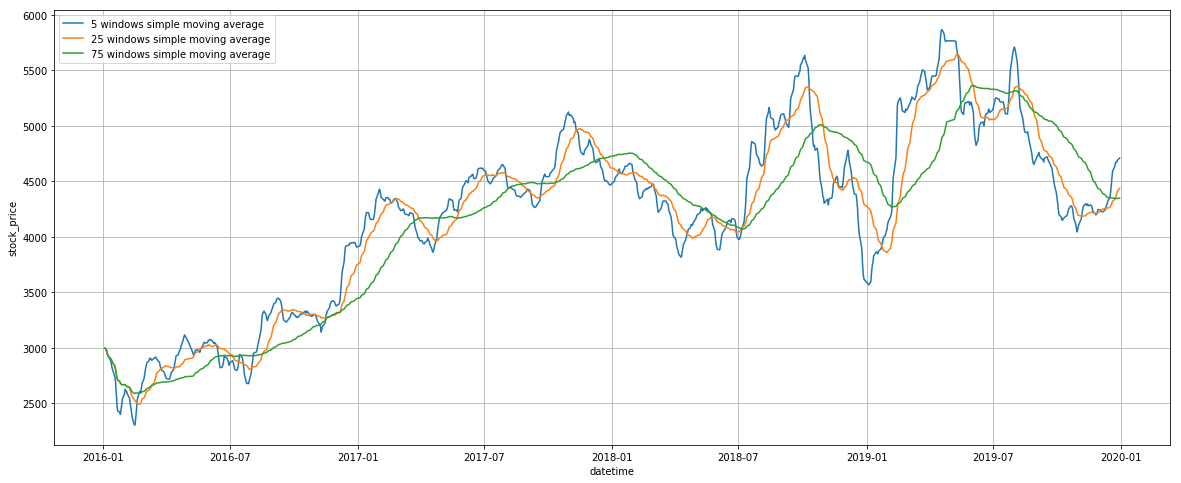

In [7]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日の移動平均を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

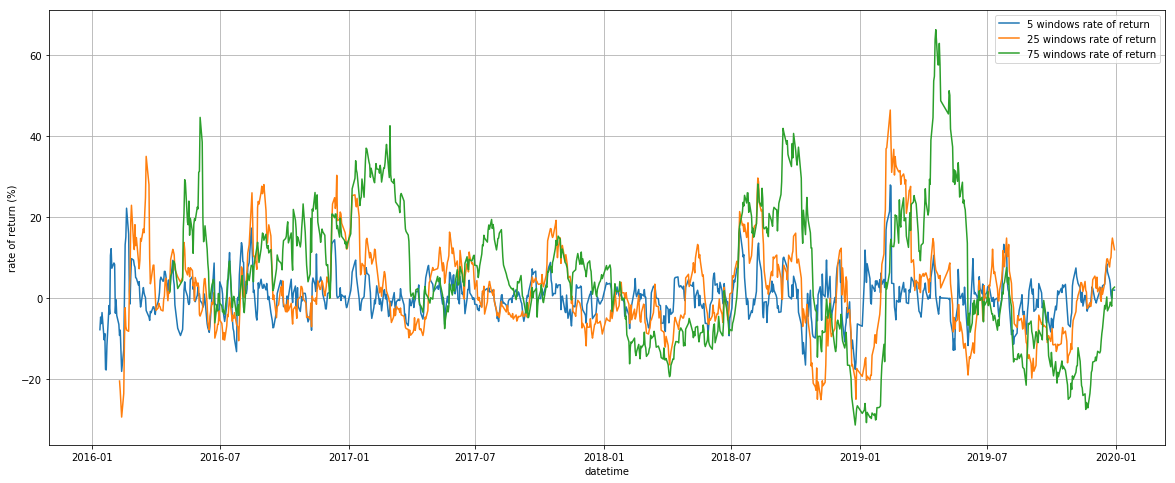

In [8]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日の価格変化率を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

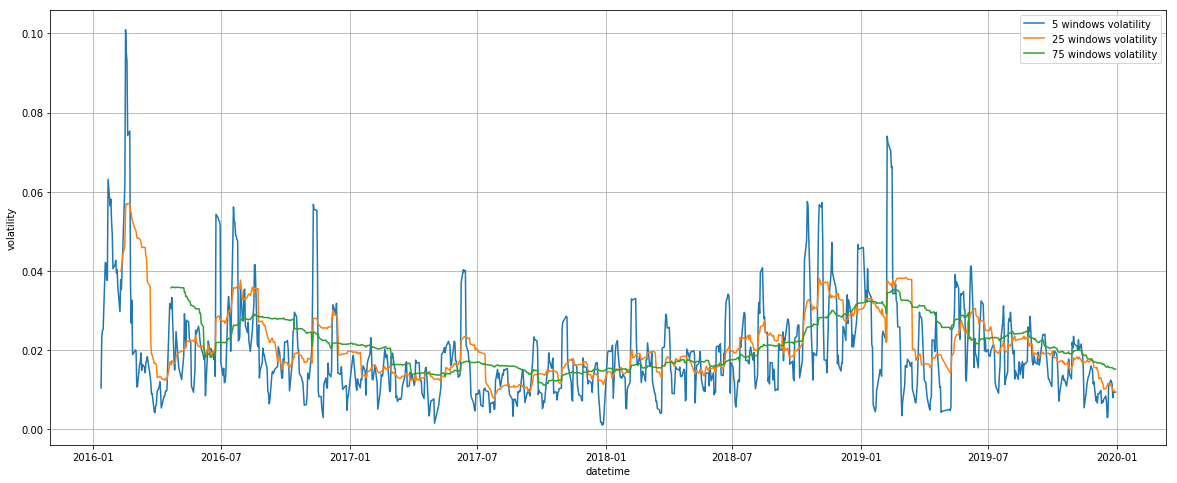

In [9]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日のヒストリカル・ボラティリティを算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

In [10]:
# stock_priceデータを読み込む
price = dfs["stock_price"]

# 銘柄コード9984にデータを絞る
code = 9984
price_data = price[price["Local Code"] == code]

# 終値のみに絞る
feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()
# 終値の20営業日リターン
feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
# 終値の40営業日リターン
feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
# 終値の60営業日リターン
feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
# 終値の20営業日ボラティリティ
feats["volatility_1month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
)
# 終値の40営業日ボラティリティ
feats["volatility_2month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
)
# 終値の60営業日ボラティリティ
feats["volatility_3month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
)
# 終値と20営業日の単純移動平均線の乖離
feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
)
# 終値と40営業日の単純移動平均線の乖離
feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
)
# 終値と60営業日の単純移動平均線の乖離
feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
)
# 欠損値処理
feats = feats.fillna(0)
# 元データのカラムを削除
feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)


In [11]:
TRAIN_END = "2017-12-31"
VAL_START = "2018-02-01"
VAL_END = "2018-12-01"
TEST_START = "2019-01-01"

In [14]:
def get_features_for_predict(dfs, code, start_dt="2016-01-01"):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"]

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["Local Code"] == code]
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # stock_priceデータを読み込む
    price = dfs["stock_price"]
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code]
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )

    # おおまかな手順の3つ目
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    # 生成対象日以降の特徴量に絞る
    feats = feats.loc[pd.Timestamp(start_dt) :]

    return feats

In [15]:
df = get_features_for_predict(dfs, 9984)
df.T

datetime,2016-02-10 00:00:00,2016-04-21 00:00:00,2016-05-10 00:00:00,2016-07-28 00:00:00,2016-11-07 00:00:00,2017-02-08 00:00:00,2017-05-10 00:00:00,2017-08-07 00:00:00,2017-11-06 00:00:00,2018-02-07 00:00:00,...,2019-05-09 00:00:00,2019-08-07 00:00:00,2019-11-06 00:00:00,2020-02-12 00:00:00,2020-04-13 00:00:00,2020-04-30 00:00:00,2020-05-18 00:00:00,2020-08-11 00:00:00,2020-10-23 00:00:00,2020-11-09 00:00:00
return_1month,-1.913212e-01,8.908766e-02,8.688554e-02,-7.610193e-02,-3.968613e-02,2.224838e-02,8.804402e-02,9.961943e-03,8.356941e-02,-5.596001e-02,...,5.914718e-02,-4.413740e-03,4.902913e-02,1.390374e-01,1.158342e-01,2.606803e-01,4.547511e-02,1.112701e-02,1.489293e-01,1.229098e-02
return_2month,0.000000e+00,1.441458e-01,2.409844e-02,-1.417147e-01,-7.741374e-02,1.144764e-01,4.466859e-02,-4.780498e-02,1.592260e-01,-6.940874e-02,...,1.015737e-01,1.675649e-02,-8.101212e-02,3.389988e-01,-2.304874e-01,-8.942610e-02,2.591281e-01,2.268081e-01,6.656627e-02,2.476660e-01
return_3month,0.000000e+00,2.555166e-01,1.739812e-01,-1.038744e-01,6.066667e-02,4.418064e-01,-3.892833e-03,4.227793e-02,1.126650e-01,-1.333666e-01,...,3.665405e-01,3.811906e-02,-1.688462e-01,3.455779e-01,-1.564571e-01,2.409372e-02,-1.624071e-01,4.041943e-01,6.576373e-02,1.438953e-01
volatility_1month,4.402584e-02,1.717726e-02,2.271106e-02,3.175834e-02,1.816612e-02,1.522609e-02,1.157811e-02,1.171816e-02,1.838358e-02,1.995841e-02,...,1.514235e-02,2.397602e-02,1.696050e-02,3.441563e-02,8.639982e-02,3.362599e-02,2.807880e-02,2.506267e-02,1.671309e-02,2.384297e-02
volatility_2month,0.000000e+00,1.705030e-02,1.818629e-02,3.062359e-02,1.717361e-02,1.409169e-02,1.290494e-02,1.194563e-02,1.601125e-02,1.687287e-02,...,1.593598e-02,2.228841e-02,1.804909e-02,2.717941e-02,6.703024e-02,6.833698e-02,6.368045e-02,2.546068e-02,2.740215e-02,2.594448e-02
volatility_3month,0.000000e+00,3.428422e-02,3.271347e-02,2.758085e-02,1.972693e-02,1.948615e-02,1.331634e-02,1.679778e-02,1.444113e-02,1.580369e-02,...,2.729567e-02,2.419688e-02,1.791320e-02,2.312453e-02,5.856385e-02,6.008750e-02,5.734101e-02,2.369026e-02,2.694665e-02,2.668409e-02
MA_gap_1month,9.107187e-01,1.071322e+00,1.008618e+00,9.588478e-01,9.694274e-01,1.012936e+00,1.066627e+00,9.912226e-01,9.996080e-01,9.540805e-01,...,1.014114e+00,9.641599e-01,1.033230e+00,1.196816e+00,1.109218e+00,1.066639e+00,1.010287e+00,9.711673e-01,1.026183e+00,1.015520e+00
MA_gap_2month,0.000000e+00,1.067462e+00,1.037082e+00,9.375874e-01,9.660428e-01,1.050702e+00,1.070177e+00,9.902299e-01,1.054210e+00,9.530104e-01,...,1.043537e+00,9.861688e-01,9.938260e-01,1.218323e+00,9.579964e-01,1.119096e+00,1.100513e+00,1.052475e+00,1.073177e+00,1.051756e+00
MA_gap_3month,0.000000e+00,1.110128e+00,1.066974e+00,9.219905e-01,9.633156e-01,1.115042e+00,1.051330e+00,1.002253e+00,1.079846e+00,9.376535e-01,...,1.073046e+00,9.971634e-01,9.581661e-01,1.260576e+00,9.266409e-01,1.031623e+00,1.043319e+00,1.123141e+00,1.079417e+00,1.073711e+00
Result_FinancialStatement FiscalYear,2.016000e+03,2.016000e+03,2.016000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2.018000e+03,2.018000e+03,2.018000e+03,...,2.019000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.021000e+03,2.021000e+03,2.021000e+03


In [16]:
def get_features_and_label(dfs, codes, feature, label):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"]
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]

        # 特定の目的変数に絞る
        labels = stock_labels[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [17]:
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(dfs, codes[0])
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(dfs, codes, feat, label)
for v in ret:
    print(v.T)

NameError: name 'tqdm' is not defined